# Anime Recommendation Data Analysis

This notebook performs exploratory data analysis (EDA) on the MyAnimeList dataset to understand user preferences, anime characteristics, and data quality for building a recommendation system.

## Table of Contents
1. [Setup and Imports](#setup-and-imports)
2. [Data Loading](#data-loading)
   - [Configuration Overview](#configuration-overview)
   - [Dataset Snapshot](#dataset-snapshot)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
   - [Ratings Distribution](#ratings-distribution)
   - [Most Rated Anime](#most-rated-anime)
   - [Genre Analysis](#genre-analysis)
   - [User Activity](#user-activity)
   - [Data Quality](#data-quality)
   - [Filtered Data Analysis](#filtered-data-analysis)
   - [Train-Test Split](#train-test-split)
   - [Data Sparsity](#data-sparsity)

<a name="setup-and-imports"></a>
## Setup and Imports 

Import necessary libraries and load configuration settings.

In [1]:
from pathlib import Path

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from collections import Counter

from rbm.constants import CONFIG_FILE, DEFAULT_FIGURE_SIZE, SEED

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = DEFAULT_FIGURE_SIZE
pd.options.display.max_columns = 20
np.random.seed(SEED)


<a name="data-loading"></a>
## Data Loading

Load the anime dataset and apply initial preprocessing filters.

<a name="configuration-overview"></a>
### Configuration Overview

Load the project configuration to understand key preprocessing thresholds and model parameters used throughout the analysis.


In [2]:
CONFIG_PATH = Path("rbm") / CONFIG_FILE
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

model_config = config["model"]
data_config = config["data"]
path_config = config["paths"]

config_summary = pd.DataFrame({section: pd.Series(values) for section, values in config.items()}).T
config_summary.index.name = "section"
config_summary


,batch_size,epochs,holdout_ratio,k,learning_rate,min_likes_anime,min_likes_user,model_path,n_hidden,output_csv
section,,,,,,,,,,
model,32.0,30.0,NaN,10.0,0.001,NaN,NaN,NaN,1024.0,NaN
data,NaN,NaN,0.1,NaN,NaN,50.0,100.0,NaN,NaN,NaN
paths,NaN,NaN,NaN,NaN,NaN,NaN,NaN,out/rbm_best_model.pth,NaN,out/recommendations.csv


<a name="dataset-snapshot"></a>
### Dataset Snapshot

Load the raw datasets, apply filtering thresholds, and review the resulting dataset sizes before proceeding with the EDA.


In [3]:
# Load data
from rbm.src.data_loader import load_anime_dataset
from rbm.src.utils import preprocess_data

raw_ratings, anime = load_anime_dataset()
display(raw_ratings.head())
display(anime.head())

raw_summary = pd.Series({
    "rows": len(raw_ratings),
    "unique_users": raw_ratings["user_id"].nunique(),
    "unique_anime": raw_ratings["anime_id"].nunique(),
    "completed_count_%": raw_ratings["status"].eq("Completed").mean(),
})

user_anime, ratings = preprocess_data(
    raw_ratings,
    min_likes_user=data_config["min_likes_user"],
    min_likes_anime=data_config["min_likes_anime"],
)

filtered_summary = pd.Series({
    "rows": len(ratings),
    "unique_users": ratings["user_id"].nunique(),
    "unique_anime": ratings["anime_id"].nunique(),
    "completed_count_%": ratings["status"].eq("Completed").mean(),
})

dataset_overview = pd.DataFrame({
    "raw_ratings": raw_summary,
    "filtered_ratings": filtered_summary,
})
dataset_overview.index.name = "metric"

count_metrics = ["rows", "unique_users", "unique_anime"]
display(
    dataset_overview
        .style
        .format("{:,.0f}", subset=pd.IndexSlice[count_metrics, :])
        .format("{:.1%}", subset=pd.IndexSlice[["completed_count_%"], :])
)

user_anime_shape = pd.Series({
    "users": user_anime.shape[0],
    "anime": user_anime.shape[1],
})
user_anime_shape.name = "user_anime_matrix"
display(user_anime_shape.to_frame().style.format("{:,.0f}"))


,user_id,anime_id,score,status,episodes_seen
0,doobiez420,52991,NaN,Watching,13.0
1,LessKk,52991,NaN,Watching,12.0
2,ByAsh156,52991,9.0,Watching,NaN
3,ShuBoxx_,52991,NaN,Plan to Watch,NaN
4,charlieleb,52991,8.0,Completed,28.0


,anime_id,name,title_english,title_japanese,type,episodes,rating,rank,popularity,members,status,source,duration,aired_from,aired_to,genre,studio,synopsis
0,52991,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,TV,28.0,9.30,1.0,142,1119371,Finished Airing,Manga,24 min per ep,2023-09-29T00:00:00+00:00,2024-03-22T00:00:00+00:00,"Adventure, Drama, Fantasy",Madhouse,During their decade-long quest to defeat the D...
1,5114,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64.0,9.10,2.0,3,3522284,Finished Airing,Manga,24 min per ep,2009-04-05T00:00:00+00:00,2010-07-04T00:00:00+00:00,"Action, Adventure, Drama, Fantasy",Bones,After a horrific alchemy experiment goes wrong...
2,9253,Steins;Gate,Steins;Gate,STEINS;GATE,TV,24.0,9.07,3.0,14,2697581,Finished Airing,Visual novel,24 min per ep,2011-04-06T00:00:00+00:00,2011-09-14T00:00:00+00:00,"Drama, Sci-Fi, Suspense",White Fox,Eccentric scientist Rintarou Okabe has a never...
3,38524,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10.0,9.05,4.0,21,2445236,Finished Airing,Manga,23 min per ep,2019-04-29T00:00:00+00:00,2019-07-01T00:00:00+00:00,"Action, Drama, Suspense",Wit Studio,Seeking to restore humanity's diminishing hope...
4,28977,Gintama°,Gintama Season 4,銀魂°,TV,51.0,9.05,5.0,343,667240,Finished Airing,Manga,24 min per ep,2015-04-08T00:00:00+00:00,2016-03-30T00:00:00+00:00,"Action, Comedy, Sci-Fi",Bandai Namco Pictures,"Gintoki, Shinpachi, and Kagura return as the f..."


,raw_ratings,filtered_ratings
metric,,
rows,"15,344,243","855,449"
unique_users,"1,130,103","1,922"
unique_anime,"26,190","12,347"
completed_count_%,51.0%,100.0%


,user_anime_matrix
users,"1,922"
anime,"12,347"


<a name="exploratory-data-analysis"></a>
## Exploratory Data Analysis

Analyze the distribution and characteristics of the data to understand user behavior and anime popularity.

<a name="ratings-distribution"></a>
### Ratings Distribution

Examine how users rate anime to understand rating patterns and potential biases.

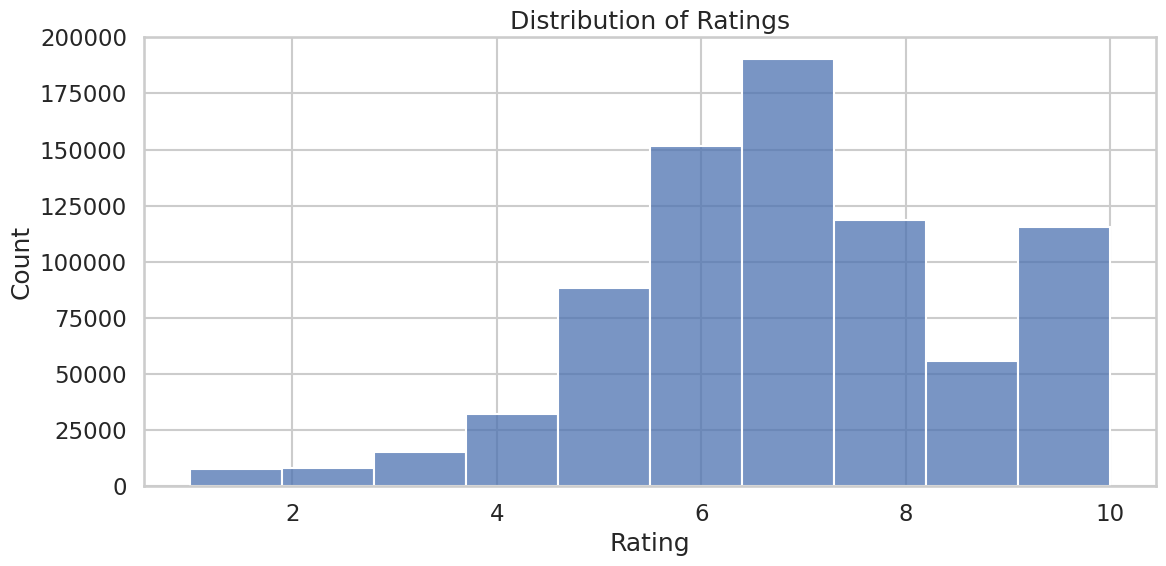

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(ratings["score"].dropna(), bins=10)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


<a name="most-rated-anime"></a>
### Most Rated Anime

Identify the most popular anime based on the number of ratings received.

User engagement concentrates on a narrow set of blockbuster titles, reinforcing the popularity bias observed in collaborative filtering datasets.


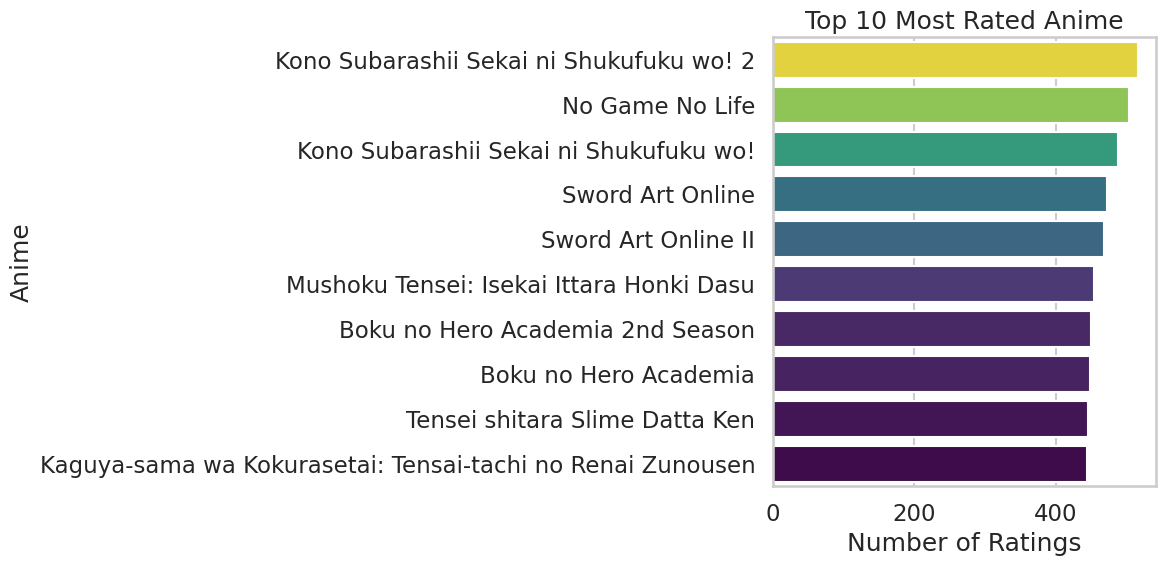

In [5]:
anime_counts = ratings["anime_id"].value_counts().head(10)
top_anime = anime[anime["anime_id"].isin(anime_counts.index)]
top_anime = top_anime.set_index("anime_id").loc[anime_counts.index]
top_anime["num_ratings"] = anime_counts.values

plt.figure(figsize=(12, 6))
sns.barplot(data=top_anime, x="num_ratings", y="name", palette="viridis", hue="num_ratings", legend=False)
plt.title("Top 10 Most Rated Anime")
plt.xlabel("Number of Ratings")
plt.ylabel("Anime")
plt.tight_layout()
plt.show()


<a name="genre-analysis"></a>
### Genre Analysis

Explore the most common genres in the anime dataset.

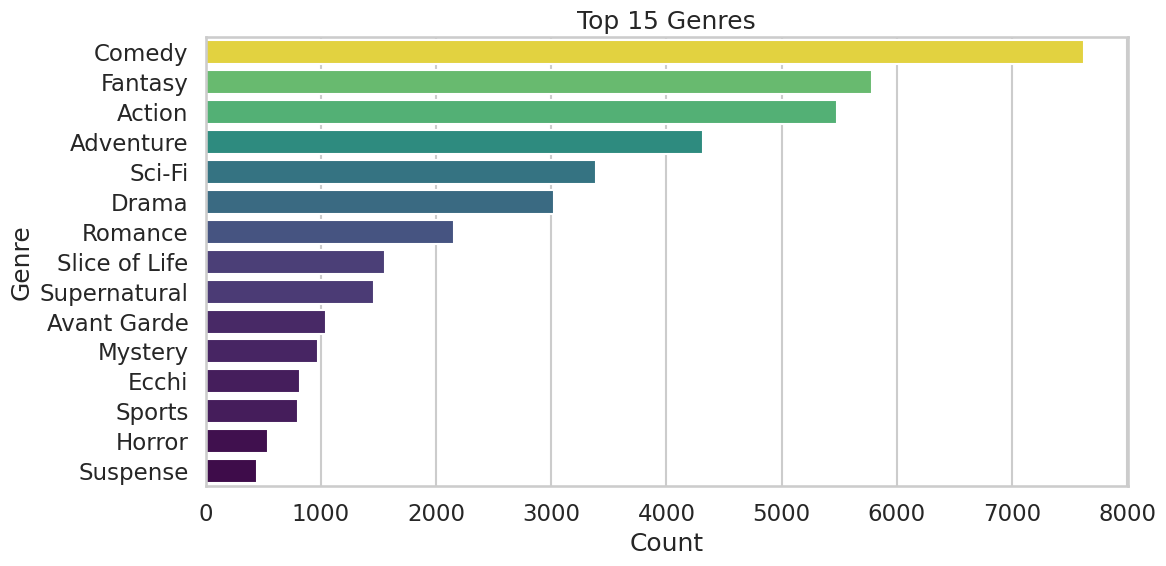

In [6]:
anime["genre"] = anime["genre"].fillna("")
all_genres = [g.strip() for genre in anime["genre"] for g in genre.split(",") if g.strip()]
genre_counts = pd.Series(Counter(all_genres)).sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis", hue=genre_counts.values, legend=False)
plt.title("Top 15 Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


<a name="user-activity"></a>
### User Activity

Analyze user engagement patterns and rating behavior.

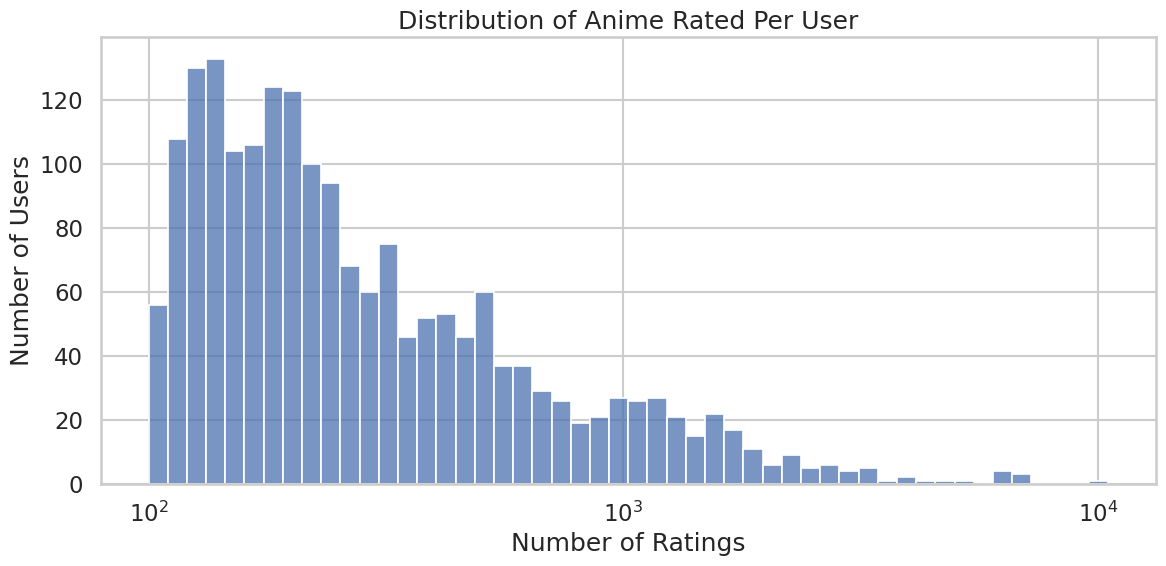

In [7]:
user_counts = ratings["user_id"].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_counts, bins=50, log_scale=True)
plt.title("Distribution of Anime Rated Per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


<a name="data-quality"></a>
### Data Quality

Check for missing values and data completeness.

In [8]:
missing_summary = pd.DataFrame({
    "ratings": ratings.isnull().sum(),
    "anime": anime.isnull().sum(),
})
missing_summary.index.name = "column"
missing_summary


,ratings,anime
column,,
aired_from,NaN,843.0
aired_to,NaN,16934.0
anime_id,0.0,0.0
duration,NaN,0.0
episodes,NaN,557.0
episodes_seen,5240.0,NaN
genre,NaN,0.0
liked,0.0,NaN
members,NaN,0.0


<a name="filtered-data-analysis"></a>
### Filtered Data Analysis

Examine the data after applying filtering criteria for active users and popular anime.

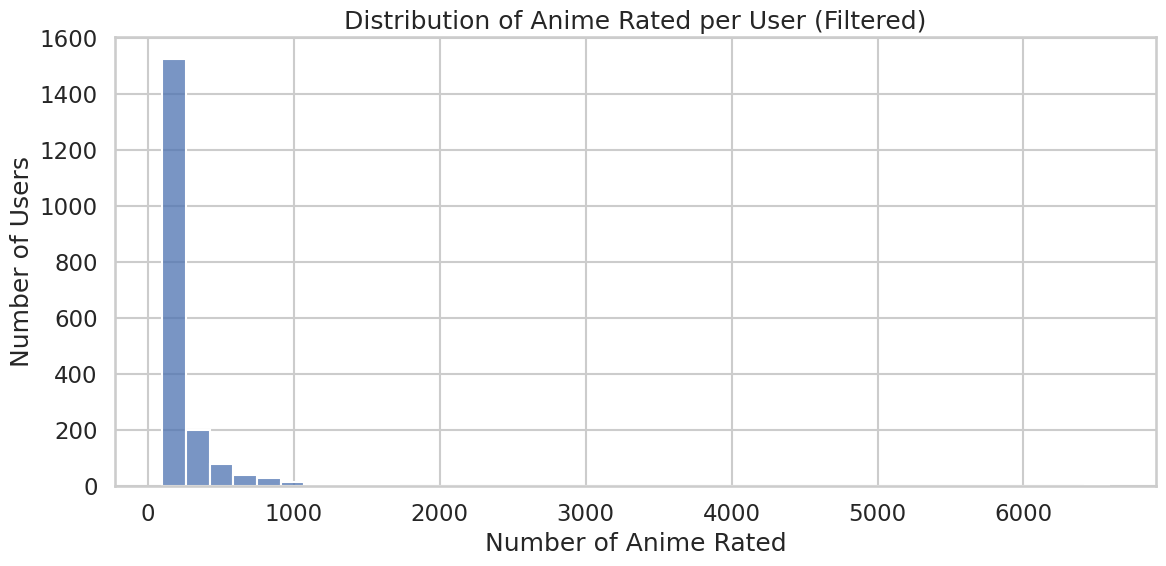

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(user_anime.sum(axis=1), bins=40)
plt.title("Distribution of Anime Rated per User (Filtered)")
plt.xlabel("Number of Anime Rated")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


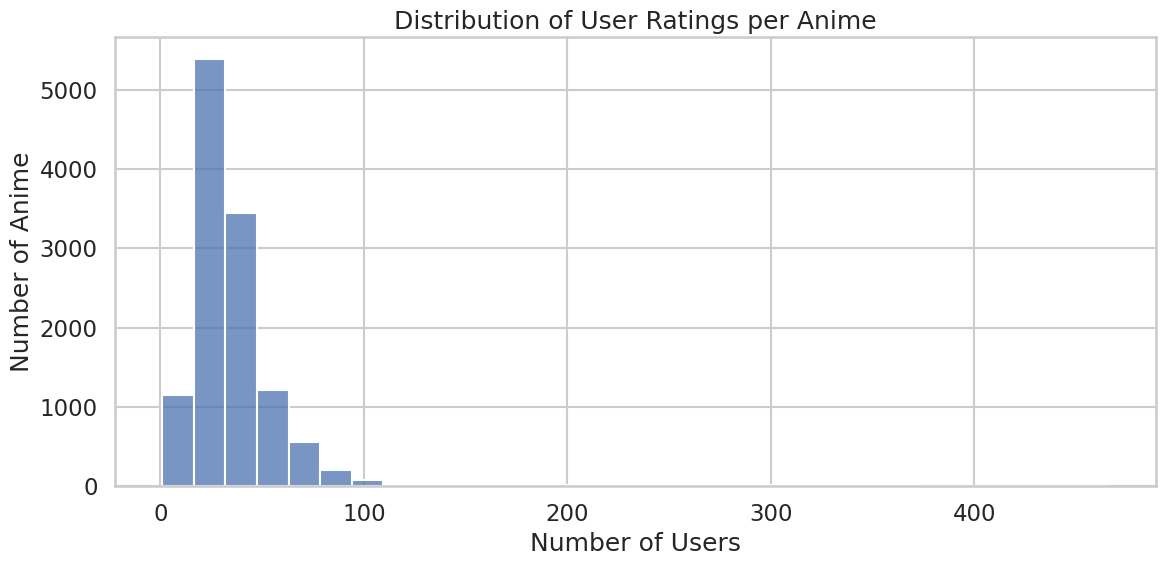

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(user_anime.sum(axis=0), bins=30)
plt.title("Distribution of User Ratings per Anime")
plt.xlabel("Number of Users")
plt.ylabel("Number of Anime")
plt.tight_layout()
plt.show()


<a name="train-test-split"></a>
### Train-Test Split

Prepare the data for model training by creating train and test sets.

In [11]:
from rbm.src.utils import make_train_test_split

train, test = make_train_test_split(user_anime, holdout_ratio=data_config["holdout_ratio"])
held_out_counts = pd.Series(test.sum(axis=1))

held_out_summary = held_out_counts.describe().rename({
    "mean": "avg_items",
    "50%": "median_items",
})
held_out_summary


count           1922.00000
avg_items         24.57128
std               43.25520
min               10.00000
25%               11.00000
median_items      15.00000
75%               23.00000
max              658.00000
dtype: float64

<a name="data-sparsity"></a>
### Data Sparsity

Visualize the sparsity of the user-anime interaction matrix.

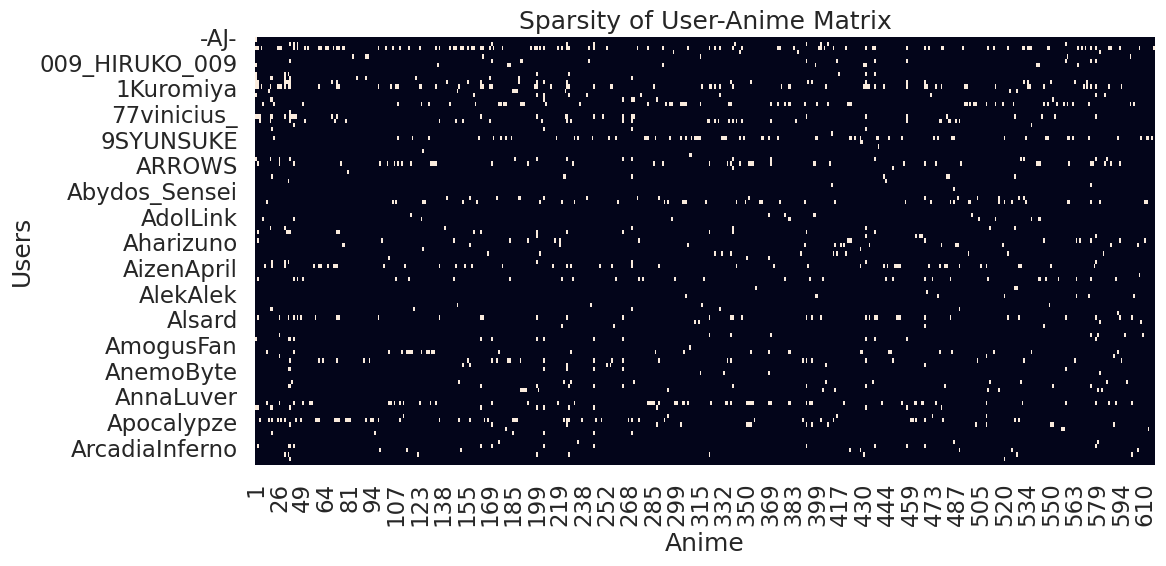

In [12]:
plt.figure(figsize=(12, 6))
sns.heatmap(user_anime.iloc[:100, :500].astype(int), cbar=False)
plt.title("Sparsity of User-Anime Matrix")
plt.xlabel("Anime")
plt.ylabel("Users")
plt.tight_layout()
plt.show()
